In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [ ]:
# --- Генеруємо дані ---
np.random.seed(42)
expense = np.linspace(0, 10, 50)
true_params = [0.2, 3.0, 5.0]  # expense_coeff, click_growth_rate, initial_clicks
noise = np.random.normal(0, 1, size=expense.shape)
output = -true_params[0]*expense**2 + true_params[1]*expense + true_params[2] + noise

In [7]:
# --- Параметри ---
mean_output = np.mean(output)
max_output = max(output) + 2

# --- Функції ---
def quadratic_function(params, x):
    expense_coeff, click_growth_rate, initial_clicks = params
    return -expense_coeff * x**2 + click_growth_rate * x + initial_clicks

def objective_function(params):
    clicks_predicted = quadratic_function(params, expense)
    SSR = np.sum((clicks_predicted - output) ** 2)
    SST = np.sum((output - np.mean(output)) ** 2)
    R_squared = 1 - SSR / SST
    return 1 - R_squared

In [8]:
# --- Мінімізація ---
initial_guess = [0.1, mean_output, 0]
result = minimize(objective_function, initial_guess, method="Nelder-Mead")
best_params = result.x

# --- Оптимум ---
expense_coeff_opt, click_growth_rate_opt, _ = best_params
optimal_expense = click_growth_rate_opt / (2 * expense_coeff_opt)
optimal_clicks = quadratic_function(best_params, optimal_expense)

In [11]:
optimal_clicks, optimal_expense, best_params

(15.831029158471358,
 7.637406097441774,
 array([0.17858643, 2.72787413, 5.41408791]))

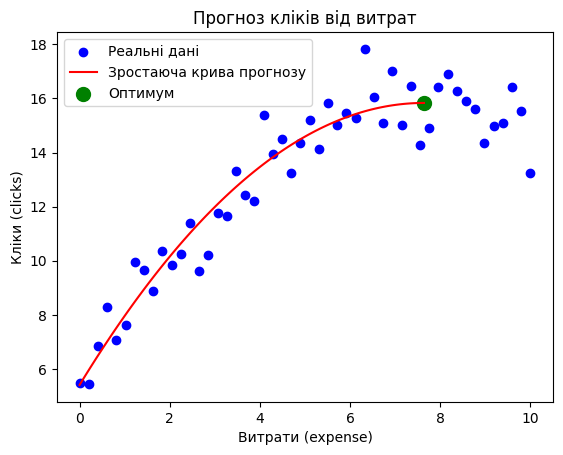

In [10]:
# --- Графік (тільки зростаюча частина) ---
x_plot = np.linspace(0, optimal_expense, 100)
y_plot = quadratic_function(best_params, x_plot)

plt.scatter(expense, output, color='blue', label='Реальні дані')
plt.plot(x_plot, y_plot, color='red', label='Зростаюча крива прогнозу')
plt.scatter(optimal_expense, optimal_clicks, color='green', s=100, label='Оптимум')
plt.xlabel("Витрати (expense)")
plt.ylabel("Кліки (clicks)")
plt.title("Прогноз кліків від витрат")
plt.legend()
plt.show()

# складна модель

In [24]:
import numpy as np
from scipy.optimize import curve_fit, minimize_scalar
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

In [25]:
def fit_and_optimize_general(x, y):
    candidates = {
        "Linear": lambda x, a, b: a*x + b,
        "Quadratic": lambda x, a, b, c: a*x**2 + b*x + c,
        "Cubic": lambda x, a, b, c, d: a*x**3 + b*x**2 + c*x + d,
        "Quartic": lambda x, a, b, c, d, e: a*x**4 + b*x**3 + c*x**2 + d*x + e,
        "Exponential": lambda x, a, b: a * np.exp(b*x),
        "Exponential + Linear": lambda x, a, b, c: a * np.exp(b*x) + c*x,
        "Logarithmic": lambda x, a, b: a * np.log(x) + b,
        "Log + Linear": lambda x, a, b, c: a * np.log(x) + b*x + c,
        "Sinusoidal": lambda x, a, b, c: a * np.sin(b*x) + c,
        "Cosinusoidal": lambda x, a, b, c: a * np.cos(b*x) + c,
        "Sin + Linear": lambda x, a, b, c, d: a*np.sin(b*x) + c*x + d,
        "Sin + Cos": lambda x, a, b, c, d: a*np.sin(b*x) + c*np.cos(d*x),
        "Linear + Exp": lambda x, a, b, c: a*x + b*np.exp(c*x),
        "Poly2 + Sin": lambda x, a, b, c, d: a*x**2 + b*x + c*np.sin(d*x)
    }

    # --- Фіт і метрики ---
    results = []
    for name, func in candidates.items():
        try:
            popt, _ = curve_fit(func, x, y, maxfev=10000)
            y_pred = func(x, *popt)
            r2 = r2_score(y, y_pred)
            mse = mean_squared_error(y, y_pred)
            results.append((name, r2, mse, popt))
        except Exception:
            results.append((name, -np.inf, np.inf, None))
    results.sort(key=lambda t: t[1], reverse=True)

    # --- Найкраща модель ---
    best_fit_name, _, _, best_params_fit = results[0]
    best_func = candidates[best_fit_name]

    # --- Оптимум по expense (X) для фіксованих параметрів ---
    def f_to_max(x_val):
        return -best_func(x_val, *best_params_fit)  # мінімізуємо -f → максимум

    opt_result = minimize_scalar(f_to_max, bounds=(min(x), max(x)), method="bounded")
    optimal_expense = opt_result.x
    optimal_value = best_func(optimal_expense, *best_params_fit)

    # --- Графік ---
    plt.figure(figsize=(8,5))
    plt.scatter(x, y, label="Синтетичні дані", color='blue')
    plt.plot(x, best_func(x, *best_params_fit), label=f"Найкраща модель: {best_fit_name}", color='red')
    plt.axvline(optimal_expense, color='green', linestyle='--', label="Оптимальний X")
    plt.axhline(optimal_value, color='purple', linestyle='--', label="Оптимальне Y")
    plt.legend()
    plt.xlabel("X / Expense")
    plt.ylabel("Y / Clicks")
    plt.title("Фіт моделей та оптимізація")
    plt.show()

    return {
        "fit_results": results,
        "best_model": best_fit_name,
        "best_params": best_params_fit,
        "optimal_x": optimal_expense,
        "optimal_y": optimal_value
    }

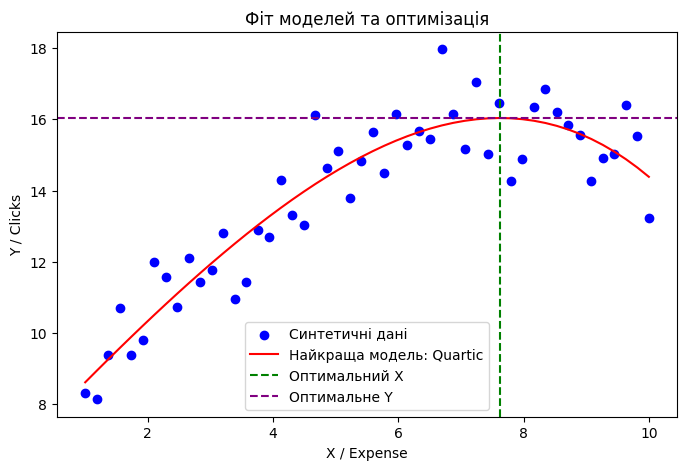

Найкраща модель: Quartic
Параметри моделі: [-3.30738783e-04 -5.03267792e-03 -2.45255936e-02  1.83775240e+00
  6.80044444e+00]
Оптимальний X: 7.623887134505534
Оптимальне Y: 16.0382682918488


In [31]:
# --- Тест на синтетичних даних ---
np.random.seed(42)
x = np.linspace(1, 10, 50)
true_params = [0.2, 3.0, 5.0]  # квадратичні параметри
noise = np.random.normal(0, 1, x.size)
y = -true_params[0]*x**2 + true_params[1]*x + true_params[2] + noise
expense = x

res = fit_and_optimize_general(x, y)
print("Найкраща модель:", res["best_model"])
print("Параметри моделі:", res["best_params"])
print("Оптимальний X:", res["optimal_x"])
print("Оптимальне Y:", res["optimal_y"])


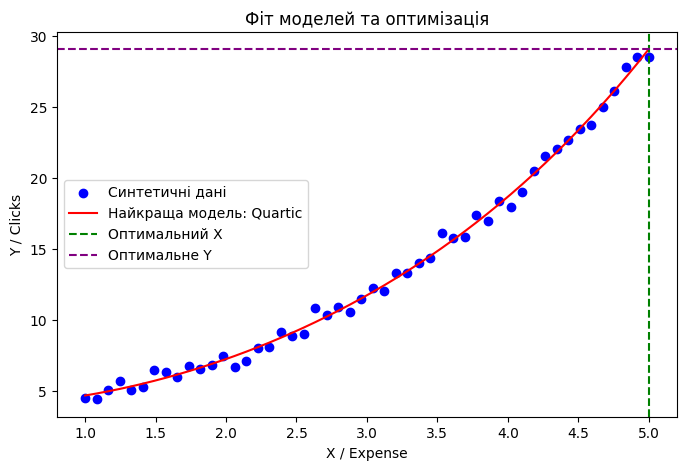

Найкраща модель: Quartic
Параметри моделі: [ 0.02022783 -0.11507134  1.1442229  -0.36867157  4.02828244]
Оптимальний X: 4.9999943713264114
Оптимальне Y: 29.04890246893463


In [30]:
# --- Тест на синтетичних даних (експонента + лінія) ---
np.random.seed(42)
x = np.linspace(1, 5, 50)
true_params = [2.0, 0.5, 1.0]  # a, b, c для exp_plus_linear
noise = np.random.normal(0, 0.5, x.size)
y = true_params[0] * np.exp(true_params[1]*x) + true_params[2]*x + noise
expense = x

res = fit_and_optimize_general(x, y)
print("Найкраща модель:", res["best_model"])
print("Параметри моделі:", res["best_params"])
print("Оптимальний X:", res["optimal_x"])
print("Оптимальне Y:", res["optimal_y"])


/var/folders/7x/q4zhf1wx08z6l2f4bqz5b8dc0000gn/T/ipykernel_73547/228332594.py:9: RuntimeWarning: divide by zero encountered in log
  "Logarithmic": lambda x, a, b: a * np.log(x) + b,
/opt/anaconda3/envs/my_env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/7x/q4zhf1wx08z6l2f4bqz5b8dc0000gn/T/ipykernel_73547/228332594.py:10: RuntimeWarning: divide by zero encountered in log
  "Log + Linear": lambda x, a, b, c: a * np.log(x) + b*x + c,
/opt/anaconda3/envs/my_env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


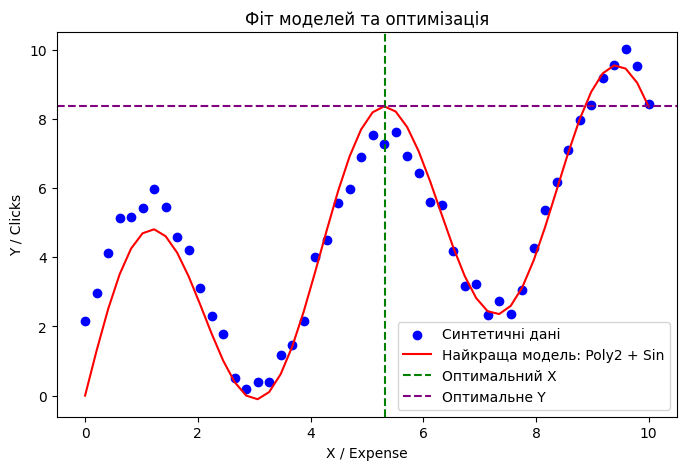

Найкраща модель: Poly2 + Sin
Параметри моделі: [-0.06847556  1.29363883  3.4494109   1.49908561]
Оптимальний X: 5.312358412614249
Оптимальне Y: 8.368490851171309


In [29]:
# --- Тест на синтетичних даних (синус + лінія) ---
np.random.seed(42)
x = np.linspace(0, 10, 50)
true_params = [3.0, 1.5, 0.5, 2.0]  # a, b, c, d для sin_plus_linear
noise = np.random.normal(0, 0.3, x.size)
y = true_params[0]*np.sin(true_params[1]*x) + true_params[2]*x + true_params[3] + noise
expense = x
res = fit_and_optimize_general(x, y)
print("Найкраща модель:", res["best_model"])
print("Параметри моделі:", res["best_params"])
print("Оптимальний X:", res["optimal_x"])
print("Оптимальне Y:", res["optimal_y"])